---
title: "Fine-Tining Kodis"
author: "Michelle Gelman"
date: "04/30/2025"
format: 
  html:
    code-fold: true
    execute:
      eval: false
      echo: True
      cache: True
jupyter: python3
---


# Corpus Pre-processing

In [2]:
%%capture
from tqdm import tqdm
from convokit import Corpus, Speaker, Utterance
from collections import defaultdict
import pandas as pd
import pprint as pp
from IPython.display import display
from modules.DataPreprocesser import DataPreprocesser
from modules import CorpusUtils as corp
import torch
import pickle

# Add the src directory to the path
import sys
import os

# Add the src
sys.path.append(os.path.abspath("."))
import import_ipynb

#Convokit Imports
from convokit.forecaster.CRAFTModel import CRAFTModel
from convokit.forecaster.forecaster import Forecaster

from modules.DataPreprocesser import DataPreprocesser
from modules import CorpusUtils as corp

### Corpus Imports

In [3]:
from convokit import download, Corpus, Forecaster, CRAFTModel
from functools import partial

In [8]:
corpus = Corpus(filename=download("conversations-gone-awry-corpus"))

Dataset already exists at /Users/mishkin/Desktop/Research/Convo_Kit/ConvoKit_Disputes/data/convokit_datasets/conversations-gone-awry-corpus


In [4]:
filepath = "/Users/mishkin/Desktop/Research/Convo_Kit/ConvoKit_Disputes/data/preprocessed_dyads.csv"
final_data = DataPreprocesser(filepath)
corpus_kodis = corp.corpusBuilder(final_data)

2107


/Users/mishkin/Desktop/Research/Convo_Kit/ConvoKit_Disputes/src/modules/DataPreprocesser.py:111: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1702723625' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  self.utterancesDF.loc[13988, 'timestamp']= '1702723625'
27498it [00:00, 38054.30it/s]


### Tagging Submit Agreements

### Tagging final utterances and Submit agreement

In [ ]:
from convokit import Corpus

# load your corpus however you normally do:
# e.g. corpus = Corpus("path/to/my/corpus")

for conv in corpus_kodis.iter_conversations():  
    # grab utterances in chronological order
    uts = conv.get_chronological_utterance_list()  
    if not uts:
        continue  
    last_utt = uts[-1]  
    # add the metadata tag
    last_utt.add_meta("exclude", True)

    # 2) tag any utterance in this conversation whose text contains "Submitted agreement"
    for utt in conv.iter_utterances():
        if "Submitted agreement" in utt.text:
            utt.add_meta("exclude", True)



### Adding Conversation Labels

In [22]:
for idx, row in final_data.getDataframe().iterrows():
    convo_id = f"utt0_con{idx}"  # generate conversation_id format from index
    label = row["dispute_outcome"]  # update if your label column is named differently
    if convo_id in corpus_kodis.conversations:
        corpus_kodis.get_conversation(convo_id).meta["label"] = label

In [3]:
def generic_fit_selector(context_tuple, split):
    """
    We use this generic function for both training and validation data.
    In both cases, its job is to select only those contexts for which the
    FUTURE context is empty. This is in accordance with how CRAFT was
    originally trained on CGA-CMV, taking the last context from each
    conversation ("last" defined as being up to and including the chronologically
    last utterance as recorded in the corpus)
    """
    matches_split = (context_tuple.current_utterance.get_conversation().meta["split"] == split)
    is_end = (len(context_tuple.future_context) == 0)
    return (matches_split and is_end)

def transform_selector(context_tuple):
    """
    For transform we only need to check that the conversation is in the test split
    """
    return (context_tuple.current_utterance.get_conversation().meta["split"] == "test")

### Model and Forecaster 

In [4]:
# We define the constant DEVICE to specify whether we want to run in GPU mode or CPU mode. As CRAFT is a neural model, GPU mode
# (activated with the value "cuda") is preferred. But if your machine lacks a GPU, you can change the value to "cpu" to enable
# CPU mode (noting that it will be slower)
DEVICE = "cuda"

In [25]:
model = CRAFTModel(
    initial_weights= "craft-wiki-pretrained",  # or "craft-wiki-finetuned"
    torch_device="cuda" if torch.cuda.is_available() else "cpu"
)

In [27]:
forecaster_kodis = Forecaster(
    forecaster_model=model,
    labeler="label",  # uses conversation.meta["label"]
    forecast_attribute_name="prediction",
    forecast_prob_attribute_name="pred_score"
)

In [7]:
forecaster_wiki = Forecaster(
    forecaster_model=model,
    labeler="conversation_has_personal_attack",  # uses conversation.meta["label"]
    forecast_attribute_name="prediction",
    forecast_prob_attribute_name="pred_score"
)

### Splitting KODIS into training/testing set

In [ ]:
import random

# Set random seed for reproducibility
random.seed(42)

# 1. Get all conversation IDs
all_convo_ids = list(corpus_kodis.get_conversation_ids())

# 2. Shuffle the conversation IDs
random.shuffle(all_convo_ids)

# 3. Define proportions
n_total = len(all_convo_ids)
n_train = int(0.7 * n_total)
n_val = int(0.1 * n_total)
n_test = n_total - n_train - n_val  # ensures 100% total

# 4. Split into train/val/test
train_convos = all_convo_ids[:n_train]
val_convos = all_convo_ids[n_train:n_train+n_val]
test_convos = all_convo_ids[n_train+n_val:]


# 5. Mark conversations with a split tag
for convo_id in train_convos:
    corpus_kodis.get_conversation(convo_id).meta["split"] = "train"
for convo_id in val_convos:
    corpus_kodis.get_conversation(convo_id).meta["split"] = "val"
for convo_id in test_convos:
    corpus_kodis.get_conversation(convo_id).meta["split"] = "test"


In [20]:
import random

# Function to get a random conversation from a split
def sample_random_convo(corpus, split_name):
    # Filter conversations by split
    split_convos = [c for c in corpus.iter_conversations() if c.meta.get("split") == split_name]
    # Choose a random one
    return random.choice(split_convos)

# Sample and print
train_sample = sample_random_convo(corpus_kodis, "train")
val_sample = sample_random_convo(corpus_kodis, "val")
test_sample = sample_random_convo(corpus_kodis, "test")

print("--- Random Train Conversation ---")
print(train_sample.get_chronological_utterance_list())

print("\n--- Random Validation Conversation ---")
print(val_sample.get_chronological_utterance_list())

print("\n--- Random Test Conversation ---")
print(test_sample.get_chronological_utterance_list())


--- Random Train Conversation ---
[Utterance({'obj_type': 'utterance', 'vectors': [], 'speaker_': Speaker({'obj_type': 'speaker', 'vectors': [], 'owner': None, 'id': 'Buyer_1511', 'temp_backend': {}, 'meta': {}}), 'owner': <convokit.model.corpus.Corpus object at 0x37d57e810>, 'id': 'utt0_con1511', 'meta': ConvoKitMeta({})}), Utterance({'obj_type': 'utterance', 'vectors': [], 'speaker_': Speaker({'obj_type': 'speaker', 'vectors': [], 'owner': None, 'id': 'Seller_1511', 'temp_backend': {}, 'meta': {}}), 'owner': <convokit.model.corpus.Corpus object at 0x37d57e810>, 'id': 'utt1_con1511', 'meta': ConvoKitMeta({})}), Utterance({'obj_type': 'utterance', 'vectors': [], 'speaker_': Speaker({'obj_type': 'speaker', 'vectors': [], 'owner': None, 'id': 'Buyer_1511', 'temp_backend': {}, 'meta': {}}), 'owner': <convokit.model.corpus.Corpus object at 0x37d57e810>, 'id': 'utt2_con1511', 'meta': ConvoKitMeta({})}), Utterance({'obj_type': 'utterance', 'vectors': [], 'speaker_': Speaker({'obj_type': 'spe

### Training KODIS

In [29]:
forecaster_kodis.fit(
    corpus_kodis, 
    partial(generic_fit_selector, split="train"), 
    val_context_selector=partial(generic_fit_selector, split="val"))

Processed 1474 context tuples for model training
Processed 210 context tuples for model validation
Loading saved parameters...
Building encoders, decoder, and classifier...
Models built and ready to go!
Building optimizers...
Starting Training!
Will train for 690 iterations
Initializing ...
Training...
Iteration: 10; Percent complete: 1.4%; Average loss: 0.6693
Iteration: 20; Percent complete: 2.9%; Average loss: 0.6593
Validating!
Iteration: 1; Percent complete: 25.0%
Iteration: 2; Percent complete: 50.0%
Iteration: 3; Percent complete: 75.0%
Iteration: 4; Percent complete: 100.0%
Validation set accuracy: 80.00%
Validation accuracy better than current best; saving model...
Iteration: 30; Percent complete: 4.3%; Average loss: 0.6530
Iteration: 40; Percent complete: 5.8%; Average loss: 0.6341
Validating!
Iteration: 1; Percent complete: 25.0%
Iteration: 2; Percent complete: 50.0%
Iteration: 3; Percent complete: 75.0%
Iteration: 4; Percent complete: 100.0%
Validation set accuracy: 80.00%


### Testing Fine-tuned Craft model
- need to filter out all "Walk away"/ "I Agree" sentences from the utterances

In [ ]:
corpus_kodis = forecaster_kodis.transform(corpus_kodis, transform_selector)

In [38]:
import pandas as pd

# 1. get utterances and conversations tables
utt_df = corpus_kodis.get_utterances_dataframe()
conv_df = corpus_kodis.get_conversations_dataframe()

# 2. find all conversation IDs in the 'test' split
test_convo_ids = conv_df[conv_df['meta.split'] == 'test'].index.tolist()

# 3. filter utterances whose conversation_id is in that list
test_utts = utt_df[utt_df['conversation_id'].isin(test_convo_ids)]
display(test_utts)
print("Threshold =", model._decision_threshold)


,timestamp,text,speaker,reply_to,conversation_id,meta.craft_tokens,meta.prediction,meta.pred_score,vectors
id,,,,,,,,,
utt0_con1,1699389969,Hello. I need you to make this right. This is ...,Buyer_1,None,utt0_con1,"[hello, ., i, need, you, to, make, this, right...",0.0,0.493907,[]
utt1_con1,1699389993,can you explain the problem with the product?,Seller_1,utt0_con1,utt0_con1,"[can, you, explain, the, problem, with, the, p...",0.0,0.493238,[]
utt2_con1,1699390064,Sorry. Guess i should have started with that. ...,Buyer_1,utt1_con1,utt0_con1,"[sorry, ., guess, i, should, have, started, wi...",0.0,0.500236,[]
utt3_con1,1699390107,the website clearly states that this is a cham...,Seller_1,utt2_con1,utt0_con1,"[the, website, clearly, states, that, this, is...",0.0,0.497745,[]
utt4_con1,1699390191,I have burnt by online purchase before. Therfo...,Buyer_1,utt3_con1,utt0_con1,"[i, have, burnt, by, online, purchase, before,...",0.0,0.501752,[]
...,...,...,...,...,...,...,...,...,...
utt13_con2105,1718876680,Thank you. I will ensure that I leave a good r...,Seller_2105,utt12_con2105,utt0_con2105,"[thank, you, ., i, will, ensure, that, i, leav...",0.0,0.502588,[]
utt14_con2105,1718876706,"Okay, thank you.",Buyer_2105,utt13_con2105,utt0_con2105,"[okay, ,, thank, you, .]",0.0,0.506139,[]
utt15_con2105,1718876768,You have a good day now and I look forward to ...,Seller_2105,utt14_con2105,utt0_con2105,"[you, have, a, good, day, now, and, i, look, f...",0.0,0.512604,[]


Threshold = 0.570617


In [48]:
# 1. Get the utterances DataFrame
utt_df = corpus_kodis.get_utterances_dataframe()

# 2. Filter to only those rows where meta.prediction == 1
pred1_df = test_utts[test_utts['meta.prediction'] == 1]

# 3. pred1_df is already a DataFrame containing all utterance IDs and columns
display(pred1_df)

# 3) compute length (count of utterances) per conversation
conversation_lengths = (
    utt_df
    .groupby('conversation_id')
    .size()
    .rename('length')
)

# 4) pick out only the conversations that appeared in pred1_df
lengths_df = (
    conversation_lengths
    .loc[pred1_df['conversation_id'].unique()]
    .reset_index()           # makes 'conversation_id' a column again
)

display(lengths_df)


,timestamp,text,speaker,reply_to,conversation_id,meta.craft_tokens,meta.prediction,meta.pred_score,vectors
id,,,,,,,,,
utt13_con65,1701466508,I Walk Away.,Buyer_65,utt12_con65,utt0_con65,"[i, walk, away, .]",1.0,0.640261,[]
utt11_con135,1701717829,I Walk Away.,Seller_135,utt10_con135,utt0_con135,"[i, walk, away, .]",1.0,0.571357,[]
utt12_con139,1701718587,I Walk Away.,Seller_139,utt11_con139,utt0_con139,"[i, walk, away, .]",1.0,0.630753,[]
utt11_con191,1701804587,I Walk Away.,Buyer_191,utt10_con191,utt0_con191,"[i, walk, away, .]",1.0,0.639177,[]
utt21_con433,1702059781,I Walk Away.,Seller_433,utt20_con433,utt0_con433,"[i, walk, away, .]",1.0,0.59606,[]
utt10_con487,1702079029,I Walk Away.,Buyer_487,utt9_con487,utt0_con487,"[i, walk, away, .]",1.0,0.607626,[]
utt11_con542,1702424397,I Walk Away.,Seller_542,utt10_con542,utt0_con542,"[i, walk, away, .]",1.0,0.599599,[]
utt10_con543,1702424625,I Walk Away.,Buyer_543,utt9_con543,utt0_con543,"[i, walk, away, .]",1.0,0.601956,[]
utt10_con614,1702497046,I Walk Away.,Buyer_614,utt9_con614,utt0_con614,"[i, walk, away, .]",1.0,0.599737,[]


,conversation_id,length
0,utt0_con65,14
1,utt0_con135,12
2,utt0_con139,13
3,utt0_con191,12
4,utt0_con433,22
5,utt0_con487,11
6,utt0_con542,12
7,utt0_con543,11
8,utt0_con614,11
9,utt0_con643,13


In [46]:
%%capture
conv_df, metrics = forecaster_kodis.summarize(
    corpus_kodis,
    selector=lambda convo: convo.meta["split"] == "test"
)

Average conversation length in KODIS test set: 13.06 utterances

── OVERALL TEST-SET METRICS ──


,Accuracy,Precision,Recall,FPR,F1
kodis_model,0.874704,1.0,0.273973,0.0,0.430108


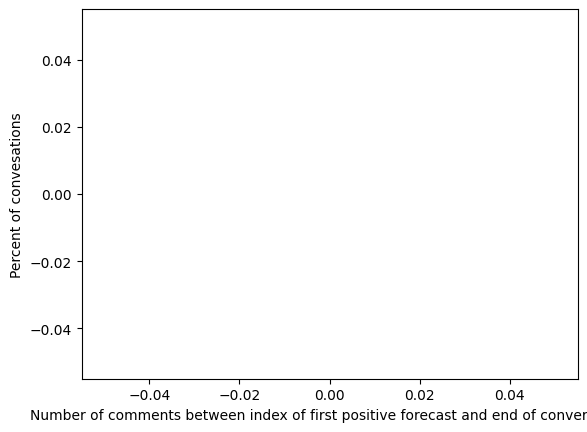

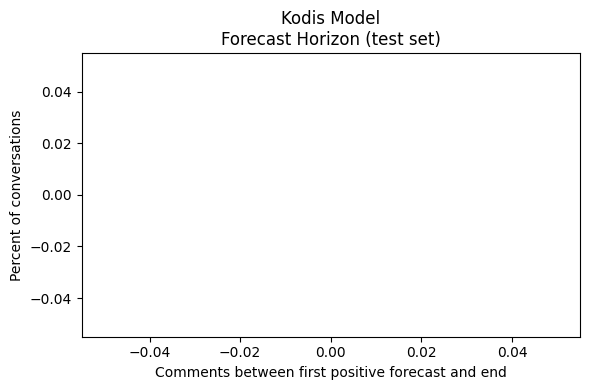

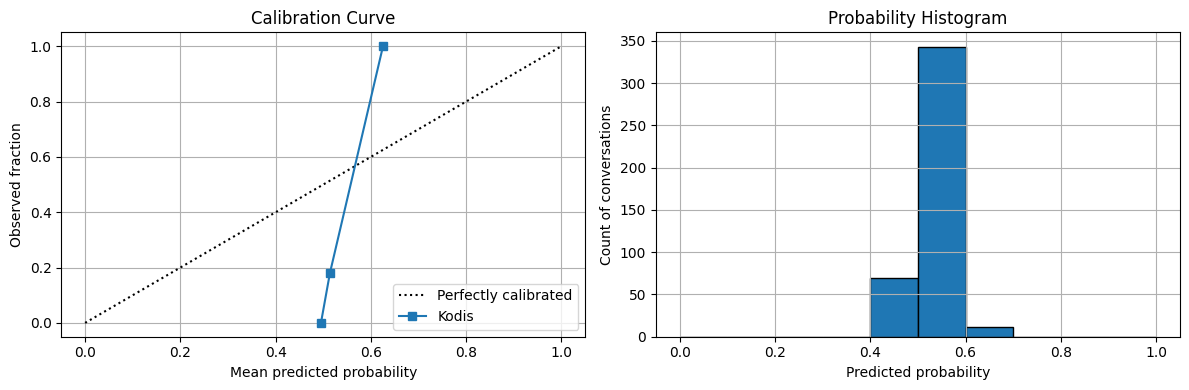

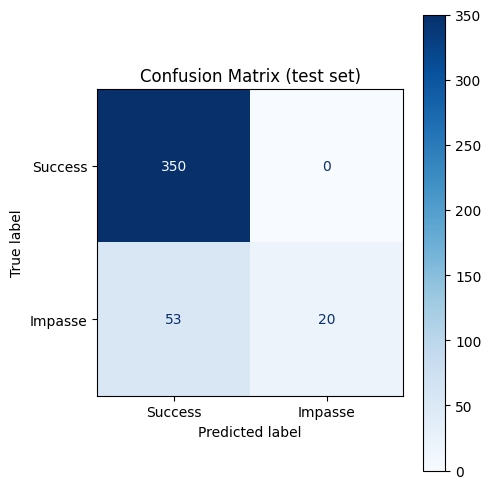

── Summary Statistics ──


,kodis_acc,avg_pred_prob,agreement_rate
conversation_level,0.874704,0.513798,0.874704


In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.calibration import CalibrationDisplay

# 1) Average conversation length (test split)
lengths = [
    len(convo.get_utterance_ids())
    for convo in corpus_kodis.iter_conversations()
    if convo.meta.get("split") == "test"
]
avg_len = sum(lengths) / len(lengths)
print(f"Average conversation length in KODIS test set: {avg_len:.2f} utterances\n")

# 2) Overall metrics table
print("── OVERALL TEST-SET METRICS ──")
metrics_df = pd.DataFrame([metrics], index=["kodis_model"])
display(metrics_df)

# 3) Forecast horizon histogram
horizon = forecaster_kodis._draw_horizon_plot(
    corpus_kodis,
    selector=lambda convo: convo.meta.get("split")=="test"
)
h_vals = np.array(list(horizon.values()))
max_h = h_vals.max() if h_vals.size else 1
bins = range(1, max_h+1)

plt.figure(figsize=(6,4))
plt.hist(h_vals, bins=bins, density=True, edgecolor="k")
plt.title("Kodis Model\nForecast Horizon (test set)")
plt.xlabel("Comments between first positive forecast and end")
plt.ylabel("Percent of conversations")
plt.tight_layout()
plt.show()

# 4) Calibration curve + probability histogram
#   First, make sure conv_df has the right columns:
#   conv_df: index = convo_id; columns = ['label','score','forecast']
y_true = conv_df["label"]
y_prob = conv_df["score"]
y_pred = conv_df["forecast"]

fig, (ax_cal, ax_hist) = plt.subplots(1,2, figsize=(12,4))

# calibration
CalibrationDisplay.from_predictions(
    y_true=y_true,
    y_prob=y_prob,
    n_bins=10,
    name="Kodis",
    ax=ax_cal
)
ax_cal.set_title("Calibration Curve")
ax_cal.set_xlabel("Mean predicted probability")
ax_cal.set_ylabel("Observed fraction")
ax_cal.grid(True)

# histogram of predicted probabilities
bins_prob = np.linspace(0,1,11)
ax_hist.hist(y_prob, bins=bins_prob, edgecolor="k")
ax_hist.set_title("Probability Histogram")
ax_hist.set_xlabel("Predicted probability")
ax_hist.set_ylabel("Count of conversations")
ax_hist.grid(True)

plt.tight_layout()
plt.show()

# 5) Confusion matrix
fig, ax_cm = plt.subplots(1,1, figsize=(5,5))
ConfusionMatrixDisplay.from_predictions(
    y_true=y_true,
    y_pred=y_pred,
    display_labels=["Success","Impasse"],
    cmap="Blues",
    ax=ax_cm
)
ax_cm.set_title("Confusion Matrix (test set)")
plt.tight_layout()
plt.show()

# 6) Summary table of accuracies & calibration
agree_rate = (y_true == y_pred).mean()
summary = pd.DataFrame({
    'kodis_acc':      [(y_true == y_pred).mean()],
    'avg_pred_prob':  [y_prob.mean()],
    'agreement_rate': [agree_rate],
}, index=["conversation_level"])
print("── Summary Statistics ──")
display(summary)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import roc_curve, precision_recall_curve, auc
from IPython.display import display

# --- 1) Helper functions ---

def get_conv_level_scores(corpus, split="test"):
    # 1) Pull conversation‐level metadata and restrict to test split
    conv_df = corpus.get_conversations_dataframe()
    test_ids = conv_df[conv_df["meta.split"] == split].index

    # 2) Pull utterance predictions and filter to test conversations
    utt = (
        corpus
          .get_utterances_dataframe()[['conversation_id','meta.pred_score']]
          .dropna()
    )
    utt = utt[utt['conversation_id'].isin(test_ids)]

    # 3) Aggregate to conversation‐level score
    conv_scores = utt.groupby('conversation_id')['meta.pred_score'].max()
    # ensure every test conversation appears (zero if never scored)
    conv_scores = conv_scores.reindex(test_ids, fill_value=0)

    # 4) Build y, scores
    y_true   = conv_df.loc[test_ids, 'meta.label'].astype(int).values
    y_scores = conv_scores.values
    return y_true, y_scores

def print_baseline_accuracy(corpus, split="test", label_field="label"):
    conv_df = corpus.get_conversations_dataframe()
    conv_df = conv_df[conv_df["meta.split"] == split]
    counts = conv_df[f"meta.{label_field}"].value_counts()
    baseline = counts.min() / counts.sum()
    print(f"Baseline accuracy (majority class on {split}): {baseline:.3f}")


# --- 2) Class balance and baseline ---

# Restrict conv_df to test split when showing counts
conv_df = corpus_kodis.get_conversations_dataframe()
conv_df = conv_df[conv_df["meta.split"] == "test"][['meta.label']]
print("Conversation‐level label counts (test split):")
display(conv_df['meta.label'].value_counts())

y, scores = get_conv_level_scores(corpus_kodis, split="test")
print(f"Positive‐class rate (test): {y.mean():.2%}")
print_baseline_accuracy(corpus_kodis, split="test")


# --- 3) ROC & PR computation ---

fpr, tpr, _ = roc_curve(y, scores)
roc_auc = auc(fpr, tpr)

prec, rec, _ = precision_recall_curve(y, scores)
order = np.argsort(rec)
pr_auc = auc(rec[order], prec[order])

print(f"ROC AUC (test): {roc_auc:.3f}")
print(f"PR  AUC (test): {pr_auc:.3f}")


# --- 4) Plot side‐by‐side ---

fig, (ax_roc, ax_pr) = plt.subplots(1, 2, figsize=(12,5))

ax_roc.plot(fpr, tpr, label=f'Test Split (AUC={roc_auc:.3f})')
ax_roc.set_xlabel('False Positive Rate')
ax_roc.set_ylabel('True Positive Rate')
ax_roc.set_title('ROC Curve')
ax_roc.legend()
ax_roc.grid(True)

ax_pr.plot(rec, prec, label=f'Test Split (AUC={pr_auc:.3f})')
ax_pr.set_xlabel('Recall')
ax_pr.set_ylabel('Precision')
ax_pr.set_title('Precision–Recall Curve')
ax_pr.legend()
ax_pr.grid(True)

plt.tight_layout()
plt.show()


NameError: name 'corpus_kodis' is not defined